In [4]:
import torch


import math
import random


def n_points(r, n, offset, randomness=0.0):
    for i in range(n):
        if randomness > 0:
            theta = (2 * math.pi * i / n + offset) * (
                1 + randomness * (random.random() - 0.5) * 2
            )
            r = r * (1 + randomness * (random.random() - 0.5) * 2)
        else:
            theta = 2 * math.pi * i / n + offset

        yield (r * math.cos(theta), r * math.sin(theta))


#


def vector_field(z, t, num_points, radius=0.5):
    score = torch.zeros_like(z)

    if z.norm() > radius + 0.1:
        nearest_neighbors = []
        for x, y in n_points(radius, num_points, math.pi / num_points + 0.5):
            dist_vec = torch.tensor([x, y]) - z
            dist = dist_vec.norm()
            nearest_neighbors.append((dist, dist_vec))

        sorted_neighbors = sorted(nearest_neighbors, key=lambda x: x[0])
        score += sorted_neighbors[0][1]

    else:
        for x, y in n_points(radius / 2, num_points, 0):
            dist_vec = torch.tensor([x, y]) - z
            dist = dist_vec.norm()
            score += dist_vec / dist.pow(2.0)

    return score / score.norm()

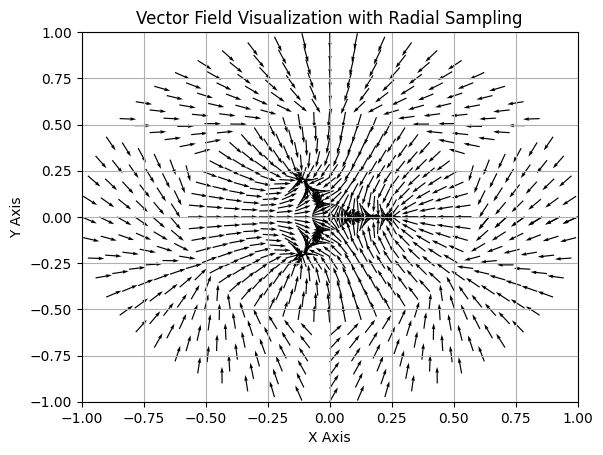

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# Create points radially
radii = np.linspace(0, 1, 15)  # You can adjust the number of points as needed
angles = np.linspace(0, 2 * np.pi, 57)
R, A = np.meshgrid(radii, angles)
X = R * np.cos(A)
Y = R * np.sin(A)

U = np.zeros_like(X)
V = np.zeros_like(Y)

# Compute the vector field at each point
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
        t = 0  # You can change the value of t as needed
        field = vector_field(z, t, 3)
        U[i, j] = field[0]
        V[i, j] = field[1]

# Plot the vector field using quiver
plt.quiver(X, Y, U, V, scale=30)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("Vector Field Visualization with Radial Sampling")
plt.grid(True)
plt.show()

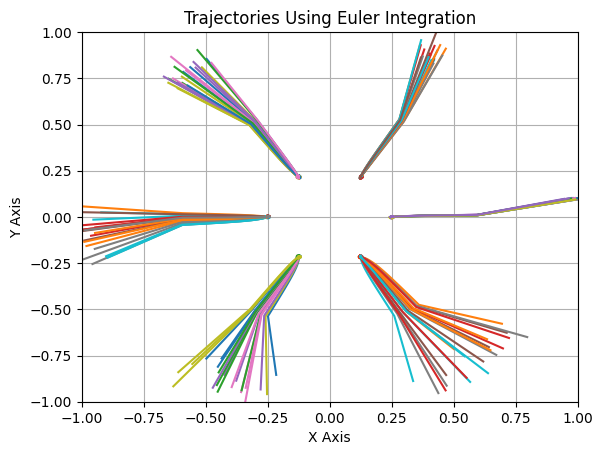

In [7]:
# Euler integration method for ODE
def euler_integration(z0, t0, tf, dt, num_points, fn):
    z = z0
    t = t0
    trajectory = [z0.numpy()]

    while t < tf:
        dz = fn(z, t)
        z = z + dz * dt
        trajectory.append(z.numpy())
        t += dt

    return np.array(trajectory)


initial_positions = []
end_positions = []

n_iteration = 20


for _ in range(n_iteration):
    initial_positions.extend(list(n_points(1, 6, 0.1, 0.05)))

# Parameters for Euler integration
t0 = 0
tf = 1
dt = 0.01
num_points = 6  # Adjust as needed

# Plot the trajectories for each initial position
for position in initial_positions:
    z0 = torch.tensor(position, dtype=torch.float32)
    trajectory = euler_integration(
        z0, t0, tf, dt, num_points, fn=lambda z, t: vector_field(z, t, num_points)
    )
    end_point = trajectory[-1]
    end_positions.append(end_point.tolist())

    plt.plot(trajectory[:, 0], trajectory[:, 1])


# Customize the plot
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("Trajectories Using Euler Integration")
plt.grid(True)
plt.show()

In [9]:
import torch.nn as nn


class VectorFieldMLP(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.linear1 = nn.Linear(2, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 2)
        self.relu = nn.ReLU()

    def forward(self, z, t):
        x = self.relu(self.linear1(z))
        x = self.linear2(x)
        return x


v1 = VectorFieldMLP(32)

In [10]:
initial_positions_pt = torch.tensor(initial_positions, dtype=torch.float32)
end_positions_pt = torch.tensor(end_positions, dtype=torch.float32)

dataloader = torch.utils.data.DataLoader(
    list(zip(initial_positions_pt, end_positions_pt)), batch_size=64, shuffle=True
)

In [ ]:
from torch.optim import Adam

optimizer = Adam(v1.parameters(), lr=1e-3)

for epoch in range(100):
    for x0, x1 in dataloader:
        optimizer.zero_grad()
        t = torch.rand_like(x0[:, 0:1])

        mid = x1 * t + x0 * (1 - t)

        loss = (x1 - x0 - v1(mid, t)).pow(2).sum()

        loss.backward()
        optimizer.step()

        print(loss.item())

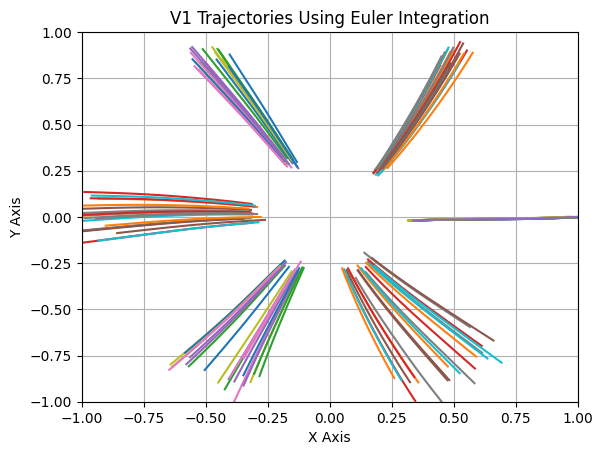

In [13]:
# Now sample from the 1-Rectified Velocity Field, v1

initial_positions = []
end_positions = []

n_iteration = 20


for _ in range(n_iteration):
    initial_positions.extend(list(n_points(1, 6, 0.0, 0.05)))

# Parameters for Euler integration
t0 = 0
tf = 1
dt = 0.01
num_points = 6  # Adjust as needed

# Plot the trajectories for each initial position
with torch.no_grad():
    for position in initial_positions:
        z0 = torch.tensor(position, dtype=torch.float32)
        trajectory = euler_integration(
            z0, t0, tf, dt, num_points, fn=lambda z, t: v1(z, t)
        )
        end_point = trajectory[-1]
        end_positions.append(end_point.tolist())

        plt.plot(trajectory[:, 0], trajectory[:, 1])


# Customize the plot
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("V1 Trajectories Using Euler Integration")
plt.grid(True)
plt.show()